**Maturity-risk for variational hedging**

This notebook is used to code and test numerical solutions of Forward-Backward Stochastic Differential Equation Systens (FBSDE) obtained through the minimization of composed risk measures that solves optimal hedging under variational preferences approach.

**Algorithm for Determining the Optimal Hedge $h_t^*$**

We consider the optimal hedging problem in incomplete markets formulated on the probability space $(\Omega, \mathcal{F}, \{\mathcal{F}_t\}_{t\in[0,T]}, \mathbb{P})$, where the underlying asset $S_t$ follows a given stochastic dynamics (GBM, Heston, or Jump-Diffusion). Let $H_t = H(S_t,t)$ be the value of the replicated derivative, $L_t$ the profit process associated with the hedging strategy $h_t$, and $\rho_u$ the composite risk-utility function defining the cost functional. The objective is to find $h_t^*$ that minimizes the terminal risk.

---

**Problem Formulation**

The admissible control $h_t$ belongs to a set $\mathcal{A}$ of progressively measurable processes satisfying integrability conditions. The problem is

$$
\inf_{h \in \mathcal{A}} J(h) := \inf_{h \in \mathcal{A}} \rho_u(L_T^h)
$$

where $L_T^h$ is the terminal profit induced by the control $h$.

---

**Forward-Backward System**

The problem is described by the following FBSDE:

*Forward Equation (asset and profit)*

$$
\begin{cases}
dS_t = \mu(t,S_t) S_t \, dt + \sigma(t,S_t) S_t \, dW_t + S_t^- dJ_t, \\
dL_t = b(t,S_t,h_t) dt + \eta(t,S_t,h_t) dW_t + \xi(t,S_t,h_t) dJ_t, \\
S_0 = s_0, \quad L_0 = 0.
\end{cases}
$$

*Backward Equation (adjoint process)*

$$
\begin{cases}
dp_t = -\nabla_L \mathcal{H}(t,S_t,L_t,h_t,p_t,q_t,r_t) \, dt + q_t dW_t + r_t d\tilde{J}_t, \\
p_T = \partial g(L_T),
\end{cases}
$$

where $g$ is the terminal cost defined by the composite risk function $\rho_u$.

---

**Hamiltonian**

The Hamiltonian of the problem is defined as

$$
\mathcal{H}(t,S,L,h,p,q,r) =
p \, b(t,S,h) + q \, \eta(t,S,h) + r \, \xi(t,S,h),
$$

where $p_t$, $q_t$, $r_t$ are adjoint processes.

The maximum condition of the **Stochastic Maximum Principle (SMP)** requires

$$
\frac{\partial \mathcal{H}}{\partial h}(t,S,L,h_t^*,p_t,q_t,r_t) = 0.
$$

---

**Structure of the Optimal Control**

In the cases considered in this work, the explicit solution of the maximum condition has the form

$$
h_t^* = \frac{\partial H}{\partial S}(S_t,t) + \Phi(S_t, p_t, q_t, r_t),
$$

where:
- $\partial H/\partial S$ is the **classical delta hedge**,
- $\Phi$ is the **variational adjustment term** depending on the risk/utility function.

---

**Backward Numerical Algorithm**

Let $t_0, t_1, \dots, t_N=T$ be a partition of $[0,T]$ with step size $\Delta t$. The algorithm is as follows:

*Step 1 – Initialization*

1. Set an initial strategy $h^{(0)}_t$ (e.g., delta hedge).  
2. Simulate $M$ trajectories of the asset $S_t$ and compute the corresponding profit $L_t$.

---

*Step 2 – Picard Iteration*

For each iteration $k=0,1,2,\dots$:

1. **Forward**: simulate the system  
   $$
   S_{n+1}^{(k)} = S_n^{(k)} + \mu S_n^{(k)} \Delta t + \sigma S_n^{(k)} \Delta W_n,
   $$
   $$
   L_{n+1}^{(k)} = L_n^{(k)} + b(t_n, S_n^{(k)}, h_n^{(k)}) \Delta t
     + \eta(t_n, S_n^{(k)}, h_n^{(k)}) \Delta W_n.
   $$

2. **Backward**: solve the BSDE for $p_t^{(k)}$:
   $$
   p_N^{(k)} = \partial g(L_T^{(k)}),
   $$
   $$
   p_n^{(k)} = \mathbb{E} \big[ p_{n+1}^{(k)} + f(t_{n+1}, S_{n+1}^{(k)}, L_{n+1}^{(k)}, p_{n+1}^{(k)}) \Delta t \mid \mathcal{F}_{t_n} \big],
   $$
   where $f = -\nabla_L \mathcal{H}$.  
   The conditional expectation is approximated using Monte Carlo regression.

3. **Computation of $q_n^{(k)}$**:
   $$
   q_n^{(k)} = \frac{1}{\Delta t} \mathbb{E} \big[ (p_{n+1}^{(k)} - p_n^{(k)}) \Delta W_n^\top \mid \mathcal{F}_{t_n} \big].
   $$

4. **Control Update**:
   $$
   h_n^{(k+1)} = \frac{\partial H}{\partial S}(S_n^{(k)}, t_n) + \Phi(S_n^{(k)}, p_n^{(k)}, q_n^{(k)}, r_n^{(k)}).
   $$

---

*Step 3 – Convergence Criterion*

Repeat Step 2 until

$$
\max_n \| h_n^{(k+1)} - h_n^{(k)} \| < \varepsilon.
$$

Upon convergence, define $h_t^* = h_t^{(k+1)}$.

---

**Result**

The algorithm above produces a sequence of admissible controls $\{h^{(k)}\}$ that converges to the optimal control $h^*$ minimizing the risk criterion. The numerical solution combines:

- **Forward simulation** of the asset and profit,  
- **Backward solution** of the adjoint BSDE,  
- **Iterative update** of the control via the Hamiltonian.


**Algorithm 1: Forward Simulation of the Process $S_t$**

**Input:** Initial value $S_0$, parameters $\mu$, $\sigma$, time step $\Delta t$, Brownian increments $\Delta W_n$, number of steps $N$, number of simulated paths $M$  
**Output:** Simulated asset paths $S_t^{(m)}$ for $m = 1, \ldots, M$

---

**begin**

1. for each path $m = 1, \ldots, M$ do  
2.   initialize $S_0^{(m)} \leftarrow S_0$  
3. end  

4. for $n = 0, \ldots, N-1$ do  
5.   for each path $m = 1, \ldots, M$ do  
6.     simulate Brownian increment $\Delta W_n^{(m)} \sim \mathcal{N}(0, \Delta t)$  
7.     update asset price  
8.       $S_{n+1}^{(m)} \leftarrow S_n^{(m)} + \mu S_n^{(m)} \Delta t + \sigma S_n^{(m)} \Delta W_n^{(m)}$  
9.   end  
10. end  

**end**

11. return $S_t^{(m)}$ for $m = 1, \ldots, M$  


**Algorithm 2: Backward Simulation of the Process $H_t$**  

**Input:** Asset paths $S_t$, Brownian increments $\Delta W_n$, time step $\Delta t$, terminal payoff $H_T = (S_T - K)^+$  
**Output:** Paths $H_t$, estimates $\partial_S H_t$, $\partial_{SS} H_t$, $\partial_t H_t$

---

**begin**

1. for each path $m = 1, \ldots, M$ do  
2.   $H_N^{(m)} \leftarrow (S_N^{(m)} - K)^+$  
3. end  

4. for $n = N-1, \ldots, 0$ do  
5.   for each path $m = 1, \ldots, M$ do  
6.     estimate $\alpha_n^{(m)}$, $\beta_n^{(m)}$ by solving  
7.       $\min_{\alpha, \beta} \sum [ H_{n+1}^{(m)} - H_n^{(m)} - \alpha \Delta t - \beta \Delta W_n^{(m)} ]^2$  
8.     update  
9.       $H_n^{(m)} \leftarrow H_{n+1}^{(m)} - \alpha_n^{(m)} \Delta t - \beta_n^{(m)} \Delta W_n^{(m)}$  
10.    compute  
11.      $\partial_S H_n^{(m)} \leftarrow \beta_n^{(m)} / (\sigma S_n^{(m)})$  
12.      $\partial_{SS} H_n^{(m)} \leftarrow [2(\alpha_n^{(m)} - \mu S_n^{(m)} \partial_S H_n^{(m)})] / [\sigma^2 (S_n^{(m)})^2]$  
13.      $\partial_t H_n^{(m)} \leftarrow [H_{n+1}^{(m)} - H_n^{(m)}]/\Delta t - \mu S_n^{(m)} \partial_S H_n^{(m)} - 0.5 \sigma^2 (S_n^{(m)})^2 \partial_{SS} H_n^{(m)}$  
14.   end  
15. end  

**end**

16. return $H_t^{(m)}$, $\partial_S H_t^{(m)}$, $\partial_{SS} H_t^{(m)}$, $\partial_t H_t^{(m)}$  



## ✅ Algorithm 3: Backward Estimation of Derivatives via Longstaff–Schwartz Regression

### **Input**
- Simulated asset paths `S_t^(m)` for `m = 1, ..., M`
- Time step `Δt`
- Terminal payoff `H_T^(m) = max(S_T^(m) - K, 0)`
- Drift `μ` and volatility `σ`

---

### **Output**
- Estimated derivatives `∂_S H_t^(m)`, `∂_{SS} H_t^(m)`, `∂_t H_t^(m)`

---

### **Steps**

1. **Initialization**
   - Set `H_N^(m) = max(S_N^(m) - K, 0)` for all `m`.
   - Initialize matrices `dH_dS`, `d2H_dSS`, `dH_dt` with zeros.

---

2. **Backward Iteration**
   - For `n = N-1, N-2, ..., 0` do:

     1. **Prepare data**
        - Take `S_n^(m)` and corresponding `H_{n+1}^(m)`.

     2. **Regression step**
        - Regress `H_{n+1}^(m)` on a polynomial basis of `S_n^(m)`:
          ```
          H_{n+1}^(m) ≈ a0 + a1 * S_n^(m) + a2 * (S_n^(m))^2
          ```
        - Obtain coefficients `a0`, `a1`, `a2`.

     3. **Estimate derivatives from regression**
        - For each path `m`:
          ```
          ∂_S H_n^(m) = a1 + 2 * a2 * S_n^(m)
          ∂_{SS} H_n^(m) = 2 * a2
          ```

     4. **Estimate ∂_t H_n^(m) via Itô formula**
        - Use:
          ```
          ∂_t H_n^(m) = [H_{n+1}^(m) - (a0 + a1 * S_n^(m) + a2 * (S_n^(m))^2)] / Δt
                        - μ * S_n^(m) * ∂_S H_n^(m)
                        - 0.5 * σ^2 * (S_n^(m))^2 * ∂_{SS} H_n^(m)
          ```

---

3. **Update for next step**
   - Optionally, update `H_n^(m)` as:
     ```
     H_n^(m) = max(a0 + a1 * S_n^(m) + a2 * (S_n^(m))^2, 0)
     ```
   - This ensures non-negativity if needed.

---

4. **End loop**

---

5. **Return**
- Arrays `dH_dS`, `d2H_dSS`, `dH_dt` with estimated derivatives for all paths and times.


**Algorithm 3: Forward Simulation of the Profit Process $L_t$**

**Input:** Simulated asset paths $S_t^{(m)}$, control $h_n^{(m)}$, time step $\Delta t$, Brownian increments $\Delta W_n^{(m)}$, parameters $\mu$, $\sigma$, derivative estimates $\partial_S H_n^{(m)}$, $\partial_{SS} H_n^{(m)}$, $\partial_t H_n^{(m)}$, number of steps $N$, number of simulated paths $M$  
**Output:** Simulated profit process $L_t^{(m)}$ for $m = 1, \ldots, M$

---

**begin**

1. for each path $m = 1, \ldots, M$ do  
2.   initialize $L_0^{(m)} \leftarrow 0$  
3. end  

4. for $n = 0, \ldots, N-1$ do  
5.   for each path $m = 1, \ldots, M$ do  
6.     compute drift coefficient  
7.       $b_n^{(m)} \leftarrow (h_n^{(m)} - \partial_S H_n^{(m)}) \mu S_n^{(m)} - \partial_t H_n^{(m)} - 0.5 \sigma^2 (S_n^{(m)})^2 \partial_{SS} H_n^{(m)}$  
8.     compute diffusion coefficient  
9.       $\eta_n^{(m)} \leftarrow (h_n^{(m)} - \partial_S H_n^{(m)}) \sigma S_n^{(m)}$  
10.    update profit  
11.       $L_{n+1}^{(m)} \leftarrow L_n^{(m)} + b_n^{(m)} \Delta t + \eta_n^{(m)} \Delta W_n^{(m)}$  
12.   end  
13. end  

**end**

14. return $L_t^{(m)}$ for $m = 1, \ldots, M$  


**Algorithm 4: Backward Solution of the BSDE for $p_t^{(k)}$**

**Input:** Simulated asset paths $S_t^{(k,m)}$, profit paths $L_t^{(k,m)}$, time step $\Delta t$, number of steps $N$, number of simulated paths $M$  
**Output:** Adjoint process $p_t^{(k,m)}$, auxiliary process $q_n^{(k,m)}$

---

**begin**

1. for each path $m = 1, \ldots, M$ do  
2.   set terminal condition $p_N^{(k,m)} \leftarrow \partial g(L_T^{(k,m)})$  
3. end  

4. for $n = N-1, \ldots, 0$ do  
5.   for each path $m = 1, \ldots, M$ do  
6.     compute  
7.       $$p_n^{(k,m)} \leftarrow \mathbb{E}\Big[ p_{n+1}^{(k,m)} + f(t_{n+1}, S_{n+1}^{(k,m)}, L_{n+1}^{(k,m)}, p_{n+1}^{(k,m)}) \Delta t \,\Big|\, \mathcal{F}_{t_n} \Big]$$  
8.     where $f = -\nabla_L \mathcal{H}$.  
9.     approximate the conditional expectation using Monte Carlo regression.  
10.   end  
11. end  

12. for $n = 0, \ldots, N-1$ do  
13.   compute $q_n^{(k)}$ as  
14.     $$q_n^{(k)} \leftarrow \frac{1}{\Delta t} \mathbb{E}\Big[ (p_{n+1}^{(k)} - p_n^{(k)}) \Delta W_n^\top \,\Big|\, \mathcal{F}_{t_n} \Big]$$  
15. end  

**end**

16. return $p_t^{(k,m)}$, $q_n^{(k,m)}$  


**Algorithm 5: Computation of $q_n^{(k)}$ and $r_n^{(k)}$**

**Input:** Adjoint process $p_t^{(k,m)}$, Brownian increments $\Delta W_n^{(m)}$, Poisson jump increments $\Delta N_n^{(m)}$, time step $\Delta t$, number of steps $N$, number of simulated paths $M$, jump intensity $\lambda$  
**Output:** Processes $q_n^{(k,m)}$ and $r_n^{(k,m)}$

---

**begin**

1. for $n = 0, \ldots, N-1$ do  
2.   for each path $m = 1, \ldots, M$ do  
3.     compute $q_n^{(k,m)}$ as  
4.       $$q_n^{(k,m)} \leftarrow \frac{1}{\Delta t} \mathbb{E}\Big[ (p_{n+1}^{(k,m)} - p_n^{(k,m)}) \Delta W_n^{(m)\top} \,\Big|\, \mathcal{F}_{t_n} \Big]$$  
5.     if jumps are present then  
6.       compute $r_n^{(k,m)}$ as  
7.       $$r_n^{(k,m)} \leftarrow \frac{1}{\lambda \Delta t} \mathbb{E}\Big[ (p_{n+1}^{(k,m)} - p_n^{(k,m)}) \Delta N_n^{(m)} \,\Big|\, \mathcal{F}_{t_n} \Big]$$  
8.   end  
9. end  

**end**

10. return $q_n^{(k,m)}$, $r_n^{(k,m)}$  


**Algorithm 6: Control Update and Convergence Criterion**

**Input:** Estimates $\partial_S H_n^{(m)}$, state variables $S_n^{(k,m)}$, adjoint process $p_n^{(k,m)}$, auxiliary processes $q_n^{(k,m)}$, $r_n^{(k,m)}$, tolerance $\varepsilon$  
**Output:** Updated control $h_n^{(k+1)}$, optimal control $h_t^*$

---

**begin**

1. for $n = 0, \ldots, N$ do  
2.   for each path $m = 1, \ldots, M$ do  
3.     update the control  
4.       $$h_n^{(k+1)} = \partial_S H_n^{(m)}(S_n^{(k)}, t_n) + \Phi(S_n^{(k)}, p_n^{(k)}, q_n^{(k)}, r_n^{(k)})$$  
5.   end  
6. end  

---

**Step 3 – Convergence Criterion**

7. Repeat Step 2 until  
8. $$
   \max_n \big\| h_n^{(k+1)} - h_n^{(k)} \big\| < \varepsilon.
   $$

9. Upon convergence, define  
10. $$
    h_t^* = h_t^{(k+1)}.
    $$

**end**

11. return $h_t^*$


Algorithm: Profit Simulation with Optimal Hedge

Input: S_paths, h_opt, dH_dS, d2H_dSS, dH_dt, mu, sigma, dW, dt, M, N
Output: L_paths (M x N), L_T (M)

Begin
    Initialize L[:,0] = 0
    For n = 0 to N-1 do
        For m = 1 to M do
            b = (h_opt[m,n] - dH_dS[m,n]) * mu * S[m,n]
                - dH_dt[m,n]
                - 0.5 * sigma^2 * (S[m,n]^2) * d2H_dSS[m,n]
            eta = (h_opt[m,n] - dH_dS[m,n]) * sigma * S[m,n]
            L[m,n+1] = L[m,n] + b * dt + eta * dW[m,n]
        EndFor
    EndFor
    Return L, L[:,-1]
End


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from OptimalHedging.GBM import GBMSimulator
from OptimalHedging.Heston import HestonSimulator
from OptimalHedging.JumpDiff import JumpDiffusionSimulator

# === (1) Set common parameters ===
S0 = 100
mu = 0.05
sigma = 0.2
t0 = 0.0
T = 1.0
N = 252
M = 1000
K = 100
seed = 123


In [29]:
gbm = GBMSimulator(S0=S0, mu=mu, sigma=sigma, K=K, t0=t0, T=T, N=N, M=M, seed=seed)

S_gbm = gbm.simulate_S()
H_gbm, dH_dS, d2H_dSS, dH_dt = gbm.simulate_H()
L_gbm = gbm.simulate_L(h0=1)
p, q = gbm.generate_adj(risk_type='es', alpha=0.05, beta=0.95)
h = gbm.update_control(eps=1e-10)
L_opt = gbm.update_L()

# Assuming L_opt is the simulated profit process (M x N)
L_T = L_opt[:, -1]  # profit at maturity for all paths
quantile_05 = np.quantile(L_T, 0.05)
mean = np.mean(L_T)

print(f"Quantile 0.05 of L_T: {quantile_05:.4f}")
print(f"Mean of L_T: {mean:.4f}")
print(f"Std of L_T:{np.std(L_T)}")




[OK] Convergence achieved in 2 iterations (diff=0.00e+00)
Quantile 0.05 of L_T: -18.7825
Mean of L_T: 5.1018
Std of L_T:12.269647830394314


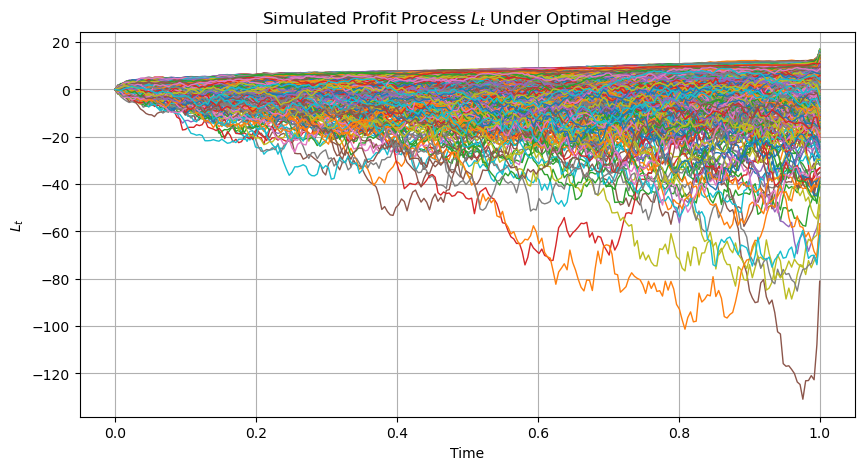

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming L_opt is (M, N) and time_grid is already defined
plt.figure(figsize=(10, 5))
# === Grid de tempo ===
time_grid = np.linspace(t0, T, N)
# Plot all sample paths (or limit if needed)
for i in range(L_opt.shape[0]):
    plt.plot(time_grid, L_opt[i], lw=1)

plt.title("Simulated Profit Process $L_t$ Under Optimal Hedge")
plt.xlabel("Time")
plt.ylabel("$L_t$")
plt.grid(True)
plt.show()



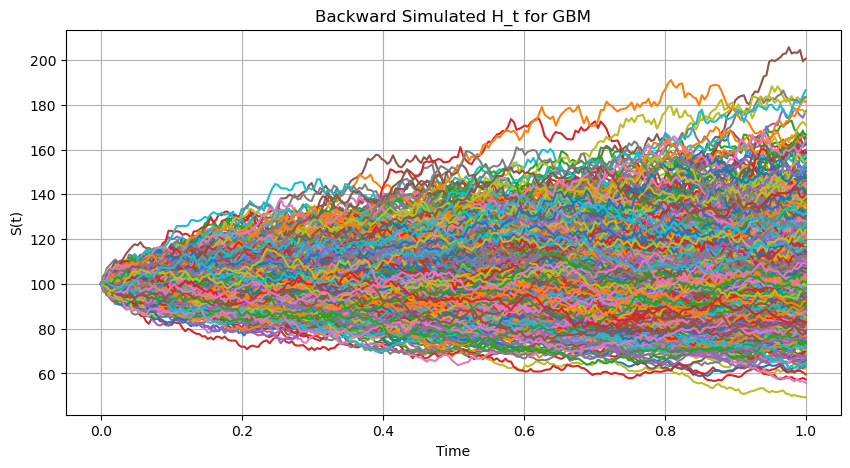

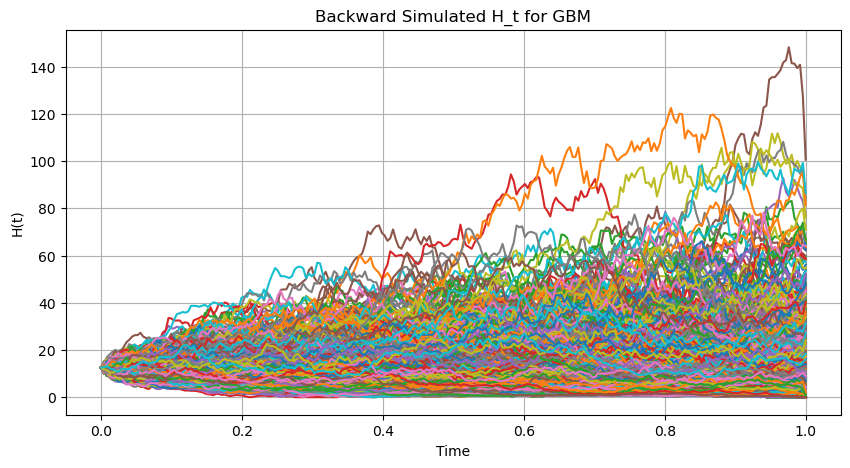

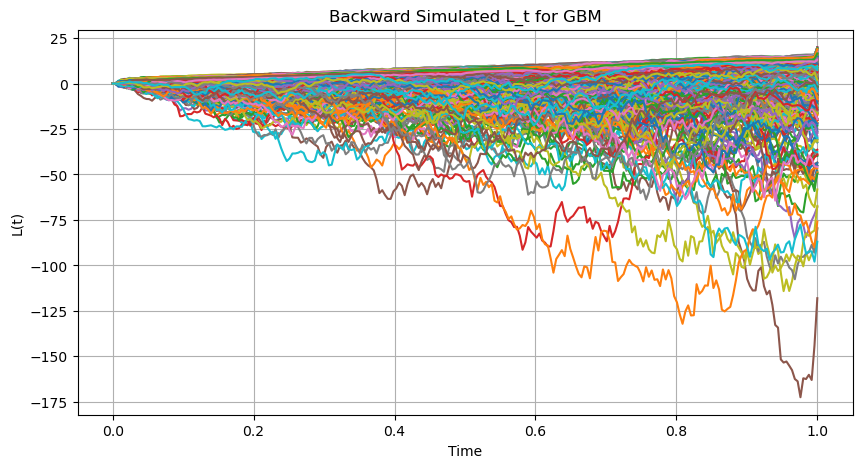

In [20]:
# === Grid de tempo ===
time_grid = np.linspace(t0, T, N)

# === Gráfico para S_t ===
plt.figure(figsize=(10, 5))
for i in range(M):
    plt.plot(time_grid, S_gbm[i])
plt.title("Backward Simulated H_t for GBM")
plt.xlabel("Time")
plt.ylabel("S(t)")
plt.grid(True)
plt.show()

# === Gráfico para H_t ===
plt.figure(figsize=(10, 5))
for i in range(M):
    plt.plot(time_grid, H_gbm[i])
plt.title("Backward Simulated H_t for GBM")
plt.xlabel("Time")
plt.ylabel("H(t)")
plt.grid(True)
plt.show()

# === Gráfico para L_t ===
plt.figure(figsize=(10, 5))
for i in range(M):
    plt.plot(time_grid, L_gbm[i])
plt.title("Backward Simulated L_t for GBM")
plt.xlabel("Time")
plt.ylabel("L(t)")
plt.grid(True)
plt.show()


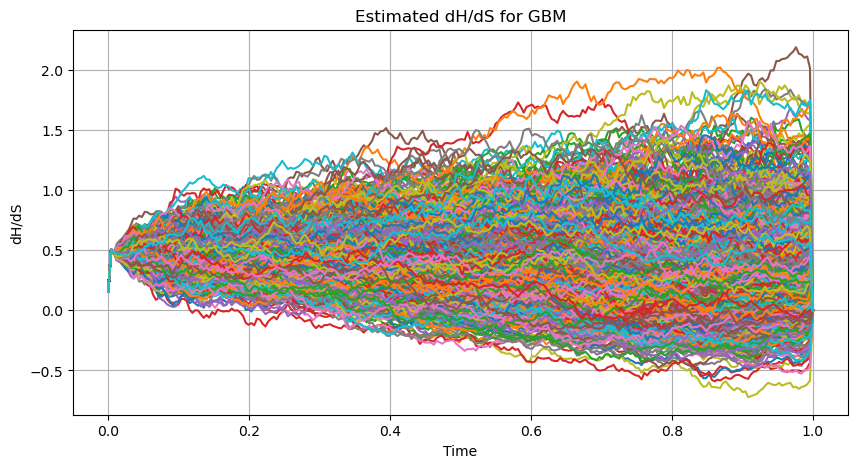

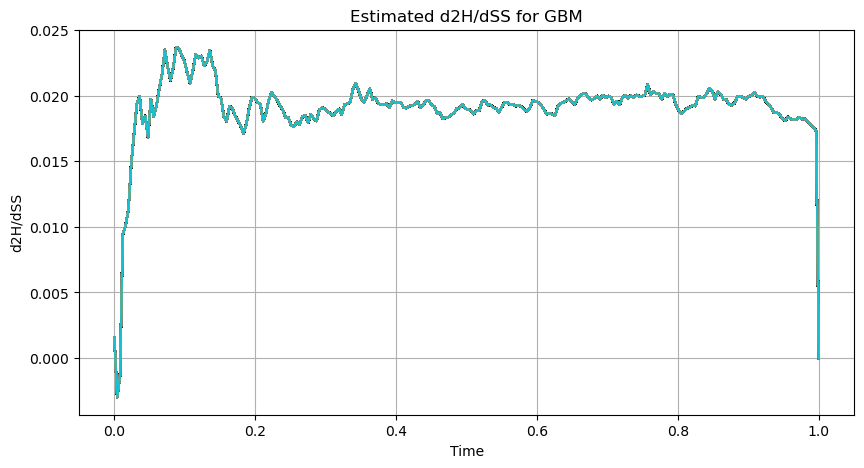

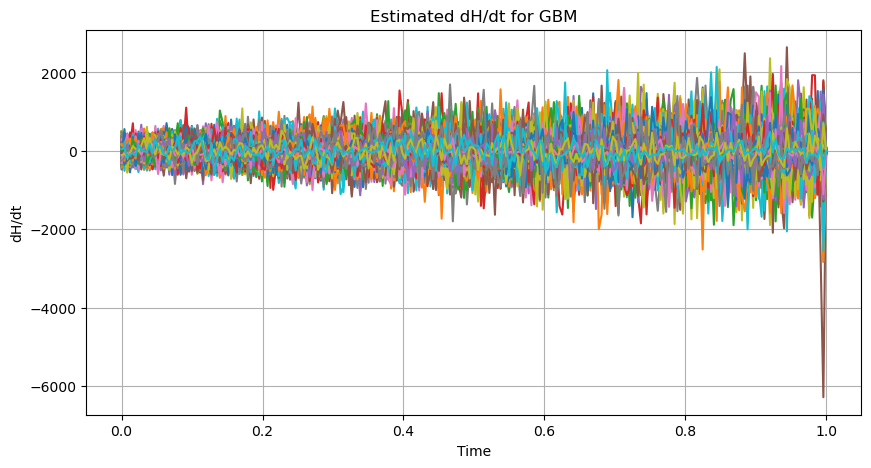

In [7]:
# === Gráfico para dH/dS ===
plt.figure(figsize=(10, 5))
for i in range(M):
    plt.plot(time_grid, dH_dS[i])
plt.title("Estimated dH/dS for GBM")
plt.xlabel("Time")
plt.ylabel("dH/dS")
plt.grid(True)
plt.show()

# === Gráfico para d2H/dSS ===
plt.figure(figsize=(10, 5))
for i in range(M):
    plt.plot(time_grid, d2H_dSS[i])
plt.title("Estimated d2H/dSS for GBM")
plt.xlabel("Time")
plt.ylabel("d2H/dSS")
plt.grid(True)
plt.show()

# === Gráfico para dH/dt ===
plt.figure(figsize=(10, 5))
for i in range(M):
    plt.plot(time_grid, dH_dt[i])
plt.title("Estimated dH/dt for GBM")
plt.xlabel("Time")
plt.ylabel("dH/dt")
plt.grid(True)
plt.show()



In [ ]:
heston = HestonSimulator(
    S0=S0, mu=mu, sigma=sigma, t0=t0, T=T, N=N, M=M, seed=seed,
    v0=0.04, kappa=2.0, theta=0.04, sigma_v=0.3, rho=-0.5
)

jump_diff = JumpDiffusionSimulator(
    S0=S0, mu=mu, sigma=sigma, t0=t0, T=T, N=N, M=M, seed=seed,
    lam=0.8, mu_J=-0.1, sigma_J=0.3
)

# === (3) Run simulations ===
S_heston, v_heston = heston.simulate()
S_jump = jump_diff.simulate()

# === (5) Plot results ===
time_grid = np.linspace(t0, T, N)

plt.figure(figsize=(10, 5))
for i in range(M):
    plt.plot(time_grid, S_heston[i])
plt.title("Heston Simulated Paths")
plt.xlabel("Time")
plt.ylabel("Asset Price")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for i in range(M):
    plt.plot(time_grid, S_jump[i])
plt.title("Jump-Diffusion Simulated Paths")
plt.xlabel("Time")
plt.ylabel("Asset Price")
plt.grid(True)
plt.show()